In [1]:
''' Import modules. '''

from scipy.interpolate import interp1d
import pywt
import tqdm
import numpy as np
import math
from copy import deepcopy
from scipy.fft import rfft, irfft, rfftfreq
from scipy import signal
import scipy.interpolate as sint
import h5py
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '/home/elott1/code')

from ColorDataUtils.DDPIutils import DDPIutils
from NDNT.utils import DanUtils as DU

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


In [2]:
''' Load ET spike data. '''

spk_datadir = '/home/elott1/data/packaged/'
spk_filename = 'J230331/Jocamo_230331_lam_CC_ETCC_nofix_v08'
spk_data = h5py.File(spk_datadir+spk_filename+'.mat')

In [3]:
''' Load ET position data. '''

dpi_datadir = '/home/dbutts/ColorV1/Data/'
dpi_filename = 'Jocamo0331_dpi_calibrated'
dpi_data = DDPIutils(filename=dpi_filename, data_dir=dpi_datadir)

Seperating trials...
Done.


In [4]:
''' Extract relevant spike info. '''

Robs = np.array(spk_data['Robs'])
RobsMU = np.array(spk_data['RobsMU'])
datafilts = np.array(spk_data['datafilts'])
datafiltsMU = np.array(spk_data['datafiltsMU'])
dt = np.array(spk_data['dt'])
spk_IDs = np.array(spk_data['spk_IDs']).squeeze() - 1
spk_times = np.array(spk_data['spk_times']).squeeze()
trialID = np.array(spk_data['trialID']).squeeze()
trial_start_ts = np.array(spk_data['trial_start_ts'])
useLeye = np.array(spk_data['useLeye'])
useReye = np.array(spk_data['useReye'])

num_trials = trial_start_ts.shape[0]
num_cells = np.unique(spk_IDs).shape[0]
num_spikes = spk_times.shape[0]

In [5]:
''' Process dpi from all trials. Takes about 1 min. per 200 trials. '''

for i in tqdm.tqdm(range(num_trials)):
    dpi_data.process_trial(tr=i, verbose=False)
    dpi_data.process_fixations(tr=i)

  0%|          | 0/1409 [00:00<?, ?it/s]

100%|██████████| 1409/1409 [06:04<00:00,  3.86it/s]


In [6]:
''' Match each spike with corresponding cell and trial. '''

num_spikes = spk_times.shape[0]
num_cells = np.unique(spk_IDs).shape[0]
num_trials = trial_start_ts.shape[0]
all_spikes = np.zeros([num_spikes,3])

for s in range(num_spikes):
    tr = spk_times[s] // 4
    time = spk_times[s] % 4
    all_spikes[s] = [time, spk_IDs[s], tr]

In [7]:
''' Calculate saccade kernel for each cell. '''

bin = 0.01
cutoff = 0.3 + bin
retro = 0.2
min_fix_len = 0.1
t = np.arange(-1*retro,cutoff,bin)

# Kernel calculations
bins_used = np.zeros(t.shape[0])
bin_counts = np.zeros([num_cells,t.shape[0]])
fix_fr = np.zeros([num_cells,t.shape[0]])
fix_spikes = []

# Kernel calculations for saccades < 1 arcmin
bins_used0 = np.zeros(t.shape[0])
bin_counts0 = np.zeros([num_cells,t.shape[0]])
fix_fr0 = np.zeros([num_cells,t.shape[0]])
fix_spikes0 = []

for c in tqdm.tqdm(range(num_cells)):
    fix_spikes.append(np.zeros(0))
    fix_spikes0.append(np.zeros(0))
    c_spk = all_spikes[all_spikes[:,1] == c]        # All spikes of cell c
    for tr in range(num_trials):
        tr_spk = c_spk[c_spk[:,2] == tr][:,0]       # Spikes of cell c during trial tr
        for i, dt in enumerate(dpi_data.fix_dt[tr]):
            start, end = dt[0]/500, dt[1]/500
            if end-start > min_fix_len and i > 0:   # Skip fixations shorter than 0.1s, and first fixations of trials
                num_bins = math.ceil((end-start+retro)/bin)
                bins_used[:num_bins] += 1
                fix_spk = tr_spk[(start-retro<tr_spk) & (tr_spk<end)] - start
                fix_spikes[c] = np.concatenate((fix_spikes[c], fix_spk))    # Accumulate all spikes that occured during a fixation
                if dpi_data.sacc_sizes[tr][i-1] < 1:    # Include in mini saccades if < 1 arcmin
                    bins_used0[:num_bins] += 1
                    fix_spikes0[c] = np.concatenate((fix_spikes0[c], fix_spk))
                
    bin_counts[c] = np.histogram(fix_spikes[c], bins=[bin*i for i in range(-1*int(retro/bin), int(cutoff/bin)+1)])[0]
    fix_fr[c] = np.divide(bin_counts[c], bins_used) / bin

    bin_counts0[c] = np.histogram(fix_spikes0[c], bins=[bin*i for i in range(-1*int(retro/bin), int(cutoff/bin)+1)])[0]
    fix_fr0[c] = np.divide(bin_counts0[c], bins_used0) / bin

rel_fix_fr = fix_fr / np.expand_dims(fix_fr.mean(axis=1), 1)
rel_fix_fr0 = fix_fr0 / np.expand_dims(fix_fr0.mean(axis=1), 1)


  0%|          | 0/59 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:31<00:00,  1.85it/s]


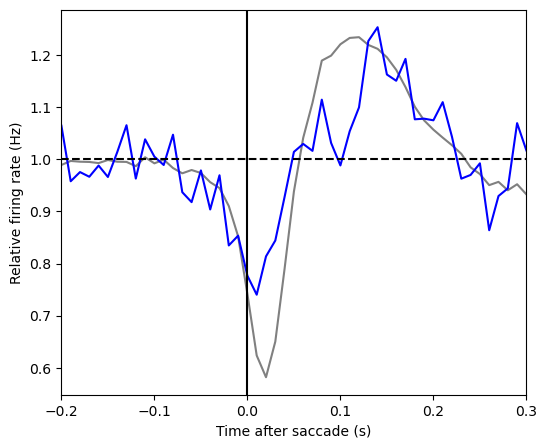

In [8]:
''' Plot average saccade kernel. '''

plt.figure(figsize=(6,5))
plt.plot(t, rel_fix_fr.mean(axis=0), color='gray')      # All saccades
plt.plot(t, rel_fix_fr0.mean(axis=0), color='blue')     # Saccades < 1 arcmin
plt.margins(x=0)
plt.xticks([-.2,-.1,0,.1,.2,.3])
plt.xlabel('Time after saccade (s)')
plt.ylabel('Relative firing rate (Hz)')
plt.axhline(y=1, color='black', linestyle='dashed')
plt.axvline(x=0, color='black')
plt.show()

In [9]:
''' Perform wavelet decompositions of all trials. '''
dpi_data.wavelet_transform()

In [10]:
''' Get all spikes lagged from each time point. Takes up to 40 min. '''

max_t = max([et.shape[0] for et in dpi_data.trial_et])
weights = np.zeros(t.shape[0])
ridx = retro/dpi_data.dt
cidx = cutoff/dpi_data.dt
lag_spikes = []

for i in range(max_t):
      lag_spikes.append(np.zeros([0,3]))

for tr in tqdm.tqdm(range(num_trials)):
      NT = dpi_data.trial_et[tr].shape[0]
      tr_spk = all_spikes[all_spikes[:,2] == tr]
      tremor = dpi_data.tremor_power[tr].sum(axis=1)
      for i in range(NT):
            start = int(max(i-ridx, 0))
            end = int(min(i+cidx, NT))
            weight_start = math.floor((start-i+ridx)/(bin/dpi_data.dt))
            weight_end = math.ceil((end-i+ridx)/(bin/dpi_data.dt))
            weights[weight_start:weight_end] += tremor[i]
            lag_spk = tr_spk[np.where((start*dpi_data.dt < tr_spk[:,0]) & (tr_spk[:,0] < end*dpi_data.dt))[0]]
            lag_spikes[i] = np.concatenate((lag_spikes[i], lag_spk), axis=0)

100%|██████████| 1409/1409 [37:44<00:00,  1.61s/it]


In [11]:
''' Caculate tremor-triggered firing rate. '''

tremor_fr = np.zeros([max_t,num_cells,t.shape[0]])

for i in range(max_t):
    start = math.floor(i/5-retro/bin)
    end = math.floor(i/5+cutoff/bin+1)
    t_spk = lag_spikes[i]
    tremor = 0
    for tr in range(num_trials):                    # Add up tremor for each time point
        trem = dpi_data.trial_et[tr].sum(axis=1)
        if i < trem.shape[0]:
            tremor += trem[i]
    for c in range(num_cells):          # Calculate lagged firing rate for each cell
        tremor_c_spk = t_spk[t_spk[:,1] == c]
        tremor_c_count = np.histogram(tremor_c_spk[:,0], bins=[bin*j for j in range(start,end)])[0]
        tremor_fr[i,c] = tremor_c_count / num_trials / bin * tremor

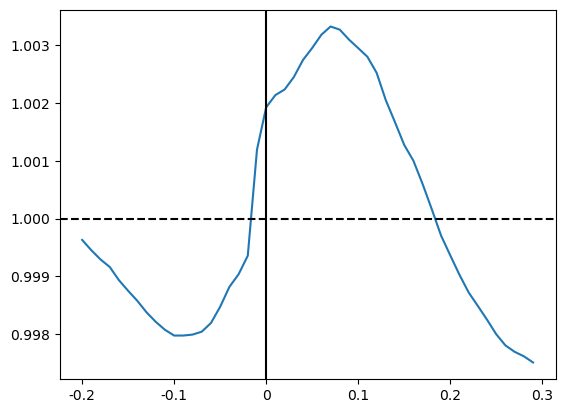

In [12]:
''' Plot average tremor kernel. '''

fr = (tremor_fr.mean(axis=0).mean(axis=0)/weights)[1:]

plt.plot(fr/fr.mean())
plt.xticks([0,10,20,30,40,50],[-.2,-.1,0,.1,.2,.3])
plt.axhline(y=1, color='black', linestyle='dashed')
plt.axvline(x=20, color='black')

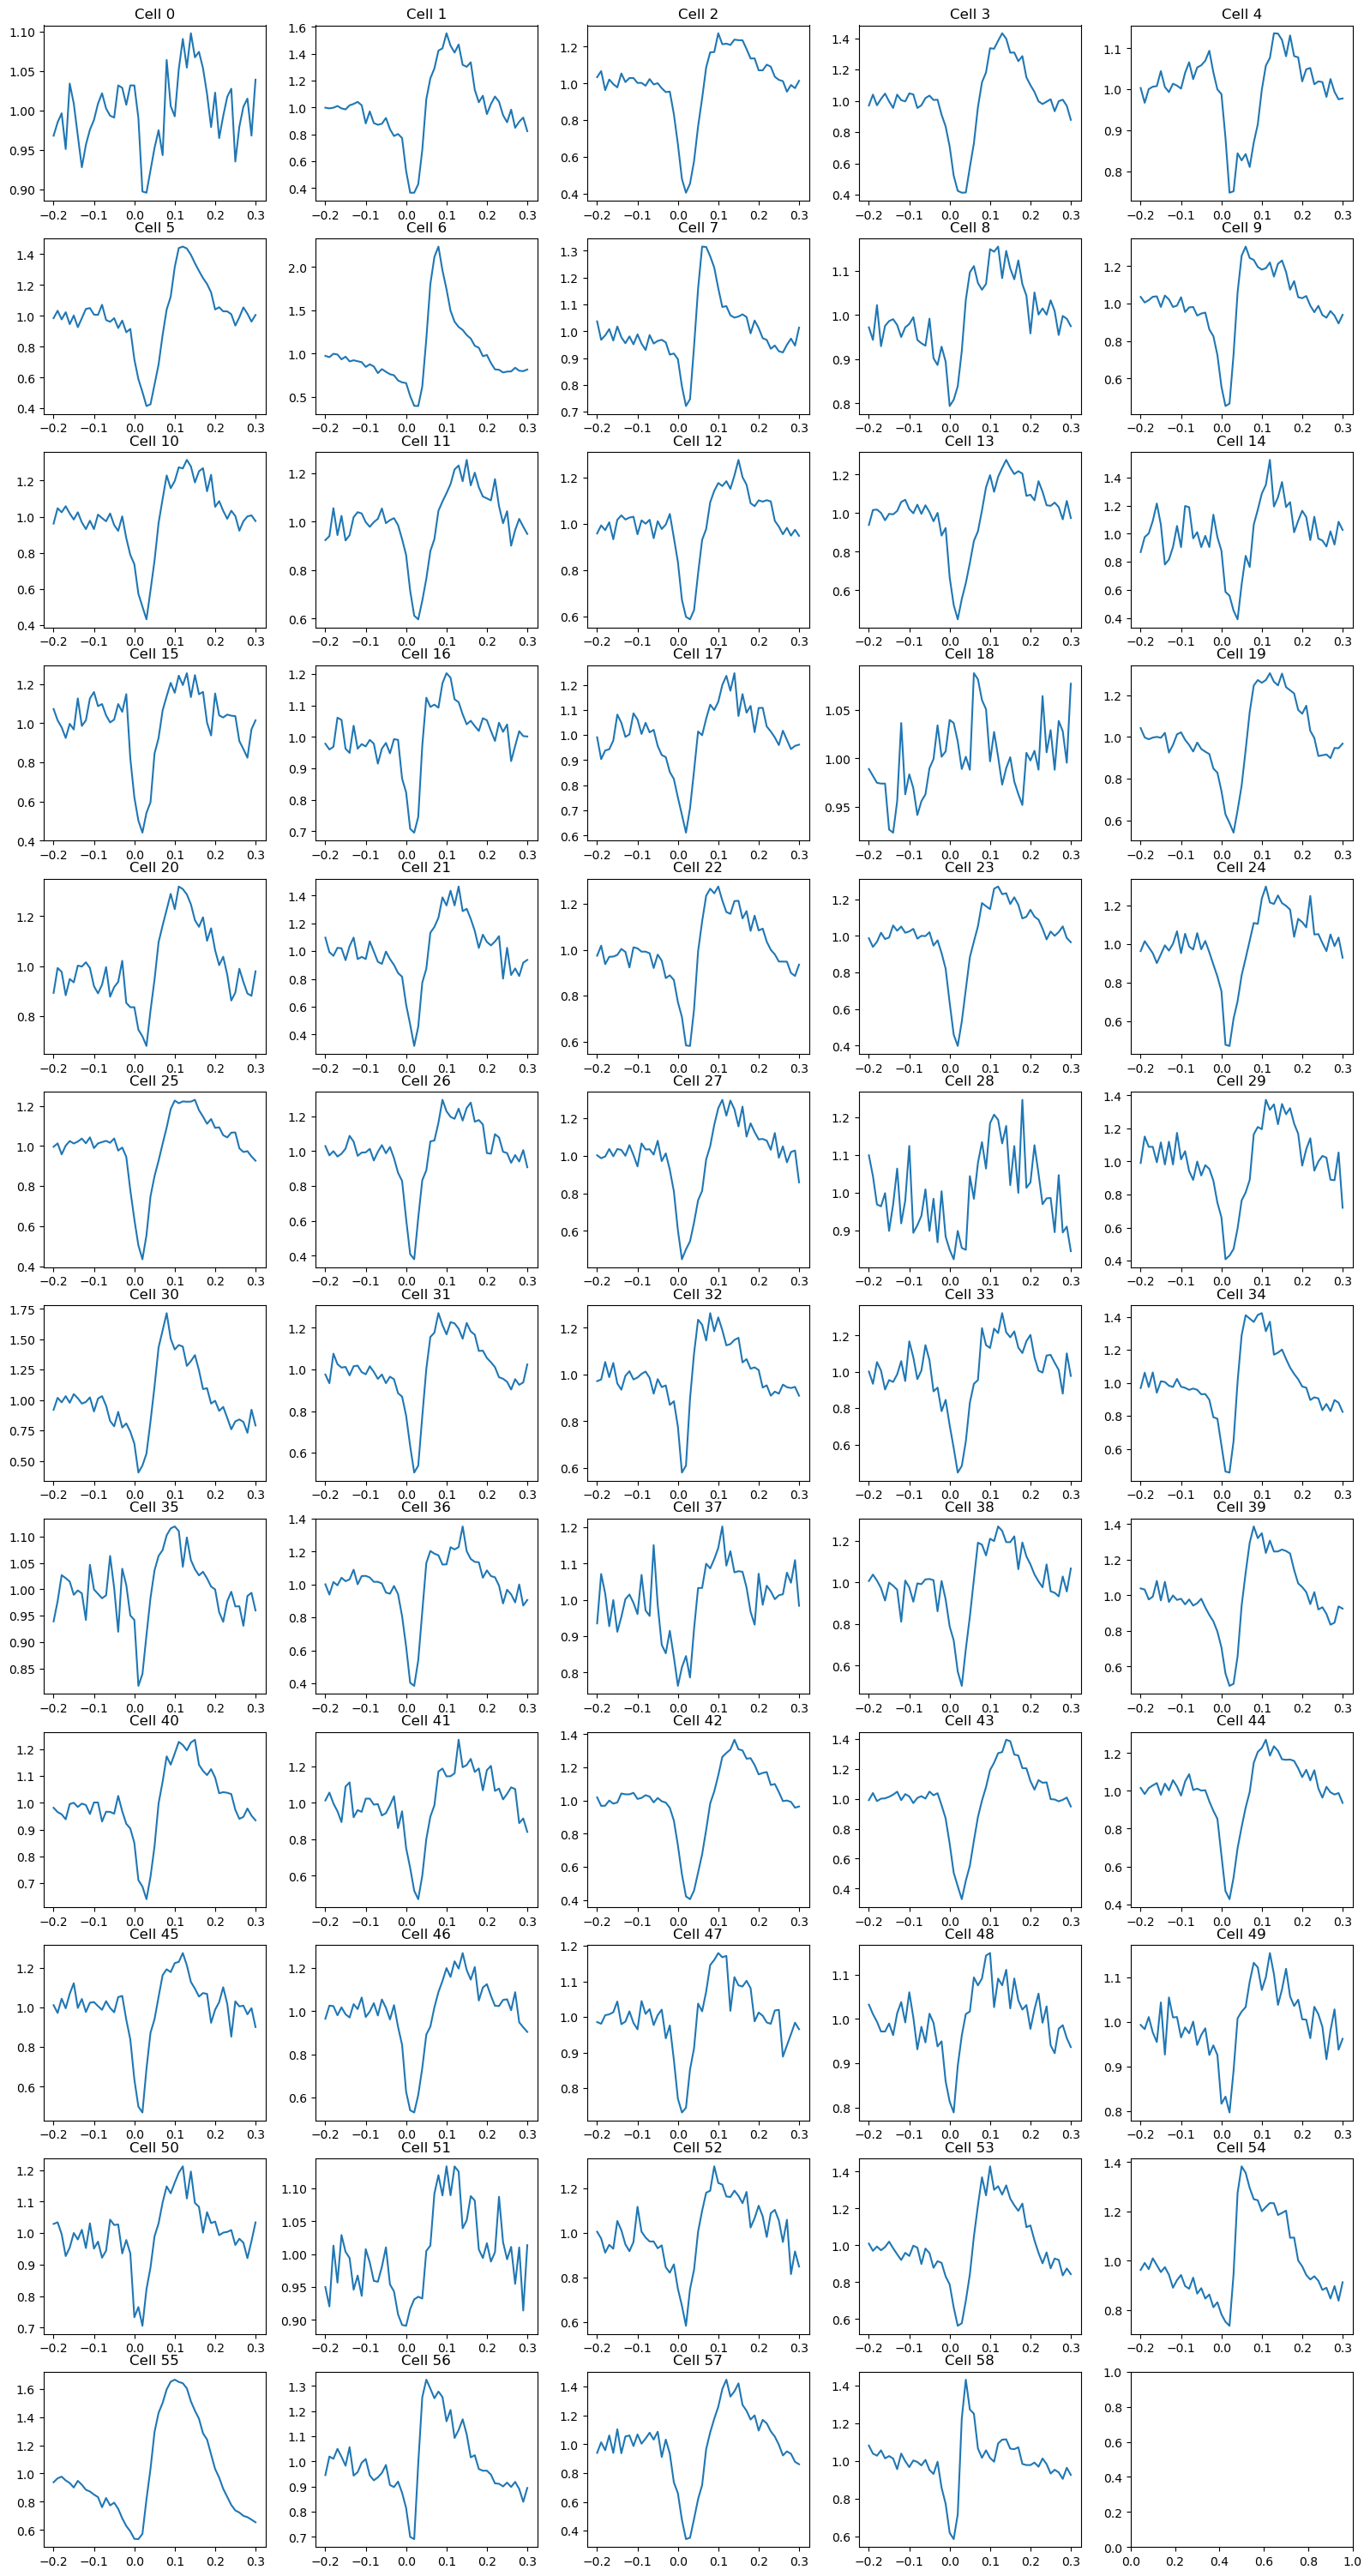

In [27]:
''' Plot fixation triggered firing rates for each cell. '''
n = num_cells
c = 5
r = math.ceil(n/c)
# fr = tremor_fr.mean(axis=0)/weights
DU.ss(r,c,rh=2.5)
for i in range(n):
    plt.subplot(r,c,i+1)
    plt.title(f'Cell {i}')
    # a = fr[i][1:]
    # b = a / a.mean()
    # plt.plot(t[1:], b)
    plt.plot(t, rel_fix_fr[i])
